In [2]:
import os
import random
import sys
import json
import datetime
import gradio as gr
import configparser
from io import StringIO
from dotenv import load_dotenv
from count_tokens import count_tokens, count_tokens_in_string
from check_valid_ini import is_valid_ini
import uuid
from search_replace import apply_translations
from example_ini import EXAMPLE_INI

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, RemoveMessage
from langchain_core.chat_history import BaseChatMessageHistory, InMemoryChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from limited_cmh import LimitedChatMessageHistory
from langchain_core.tools import tool, StructuredTool
from pydantic import BaseModel, Field
from typing import List, Dict, Annotated
from prompts import *

load_dotenv()

/home/rmuenste/code/github/python/simbot/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

### State Configuration

In [3]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver

class MyState(TypedDict):
    ini_string: str
    messages: Annotated[list, add_messages]


### Configure LLMs

In [16]:
prompt = ChatPromptTemplate.from_messages([
    ("system", BEHAVIOR_STRING),
    MessagesPlaceholder(variable_name="messages"),
])

llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.1)

chain = prompt | llm

ANALYZER_SYSTEM= f"""
You are part in a chain of LLM calls for a system that generates INI files which describe CFD simulations. Your input will be a user request. The
user can make a request where he enters one or more key-value pairs of the ini file or he can ask questions about the values in the ini file. 
Your task is to analyze the user request: if you think it is a question about values in the INI file then reply 'QUESTION' if think the request consists of
key-value pairs of the INI file then reply 'FILE_GENERATION'. 
"""


analyzer_prompt = ChatPromptTemplate.from_messages([
    (  "system",
    ANALYZER_SYSTEM 
    ),
    MessagesPlaceholder(variable_name="messages"),
])

OPENAI_MODEL_4oMini = "gpt-4o-mini"
OPENAI_MODEL_3_5_turbo="gpt-3.5-turbo"

analyzer_llm = ChatOpenAI(model=OPENAI_MODEL_3_5_turbo, temperature=0.1)

analyzer_chain = analyzer_prompt | analyzer_llm

In [5]:

def pprint_messages(messages):
    for m in messages['messages']:
        m.pretty_print()

current_date = datetime.datetime.now()
date_string_short = current_date.strftime("%m/%d/%y") 


PROMPT_TEMPLATE = """
Answer the question based only on the following context:

{context}

---

Answer the question based on the above context: {question}
"""

price_per_token = 1e-6
prompt_tokens = count_tokens_in_string(BEHAVIOR_STRING)
print(f"Token count for behavior string = {prompt_tokens}, approx. cost of prompt = {prompt_tokens * price_per_token}")

#===========================================================================
# TOOLS 
#===========================================================================
with open("translation_dict.json", "r", encoding="utf-8") as f:
    my_dict = json.load(f)

#========================================================================


#===========================================================================
# Node functions
#===========================================================================
#===========================================================================
# Translate tool node:
# The node performs a deterministic search and replace operation that
# translates a list of "tricky" keywords from German to English.
# It has no "fuzzy" component so it is not able to i.e. account for 
# spelling mistakes that a user could make.
#===========================================================================
def translate_tool(state: MyState):

    query = state["messages"][-1].content
    updated_query = apply_translations(query, my_dict)
    state["messages"][-1].content = updated_query
    return state

#===========================================================================
# Simple check node:
# The node function enforces some simple rules in the INI file and
# updates them in-place. 
#===========================================================================
def simple_check(state: MyState):

    aiMessage = state['messages']
    ini_file = state["ini_string"]
    config = configparser.ConfigParser()
    config.optionxform = str # preserve the case

    ini_stream = StringIO(ini_file)
    config_string = state["ini_string"]
    
    try:
        config.read_file(ini_stream)
        # If no sections are parsed, it's not valid
        if len(config.sections()) == 0:
            return state
    except (configparser.MissingSectionHeaderError, configparser.ParsingError):
        return state
    
    # Rule 1.
    if config['E3DGeometryData/Machine/Element_1']['type'] == "OFF_LR":
      config['E3DGeometryData/Machine/Element_1']['off_filelist'] = "undefined"
      output = StringIO()
      config.write(output)
      config_string = output.getvalue()
      output.close()
      state['messages'][-1].content = config_string

    return MyState(ini_string=config_string, messages=state["messages"])

#===========================================================================
# Simulation Bot SimBot Node:
# This function contains the main LLM call
#===========================================================================
def simBot(state: MyState):
    #print(f"This is the message state: {state['messages']}")
    response = {"messages": [chain.invoke(state["messages"])]}
    aiMessage = response['messages']
    
    msg = aiMessage[-1]
    if is_valid_ini(msg.content):
        print("LLM returned a valid INI file")
        return MyState(ini_string=msg.content, messages=response["messages"])
    else:
        print("LLM response is not an INI file")
        return MyState(messages=response["messages"])

#===========================================================================
# Filter Node:
# The node function deletes messages that are not related to the INI file
# We keep a maximum of 2 messages to reduce the amount of tokens used.
# There is still the possibility to keep a log of the full conversation,
# but not to send them to the GPT-API to save tokens.
#===========================================================================
def filter_messages(state: MyState):
    """ If none of the leftover messages is an ini file we 
        insert the ini file from the current state. We can also
        save the AIMessage in the state variable
    """

    ini_msg = state['ini_string']

    # Generate a random UUID (UUID4)
    unique_id = str(uuid.uuid4())

    if state['messages'][-1] != ini_msg:
        state['messages'].append(AIMessage(content=ini_msg, id=unique_id))

    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state['messages'][:-3]]
    return MyState(messages=delete_messages)

def output(state: MyState):
    """ Output processing node """
    #for m in state['messages']:
    #    m.pretty_print()
    return state

#===========================================================================
# Analyzer node:
#===========================================================================
def question_bot(state: MyState):
    print("I do rag")

    question = state["messages"][-1].content
    #messages = [HumanMessage(content=question)]

    response = analyzer_chain.invoke(question)
    return MyState(messages=response["messages"])


#===========================================================================
def fake_node(state: MyState):
    return state


Token count for behavior string = 1549, approx. cost of prompt = 0.001549


In [26]:
def validate_ini_schema(ini_content: str) -> bool:
    # Define the expected schema
    expected_schema = {
        "SigmaFileInfo": ["FileType", "FileVersion", "Date", "SigmaVersion", "ConfigId"],
        "E3DGeometryData": [],
        "E3DGeometryData/Machine": [
            "Type", "Unit", "Zwickel", "MachineName", "RotationDirection", "BarrelDiameter", 
            "CenterlineDistance", "BarrelStraightCut", "NoOfElements", "NoOfFlights", "BarrelLength"
        ],
        "E3DGeometryData/Machine/Element_1": [
            "GapScrewScrew", "ObjectType", "Unit", "startposition", "off_filelist", "off_filelistL", 
            "off_filelistR", "innerdiameter", "outerdiameter", "type"
        ],
        "E3DProcessParameters": [
            "ScrewSpeed", "ProcessType", "MassThroughput", "MaterialTemperature", "BarrelTemperature", 
            "ScrewTemperature", "BarrelTemperatureAdiabatic", "ScrewTemperatureAdiabatic"
        ],
        "E3DProcessParameters/Material": ["Name", "Type"],
        "E3DProcessParameters/Material/RheologicalData": ["CalcVisco", "CalcTemp"],
        "E3DProcessParameters/Material/RheologicalData/Carreau": [
            "ZeroViscosity", "RecipVelocity", "Exponent"
        ],
        "E3DProcessParameters/Material/RheologicalData/TBTS": [
            "standardtemperature", "referencetemperature"
        ],
        "E3DProcessParameters/Material/ThermoData": [
            "heatconductivity", "heatconductivityslope", "heatcapacity", "heatcapacityslope", "densitymodel"
        ],
        "E3DProcessParameters/Material/ThermoData/Density": ["Density", "DensitySlope"],
        "E3DSimulationsettings": ["MeshQuality", "HexMesher", "KTPRelease"]
    }

    # Parse the given INI content
    config = configparser.ConfigParser(allow_no_value=True, delimiters=("="))
    config.optionxform = str  # Preserve case sensitivity for keys

    try:
        config.read_string(ini_content)
    except configparser.Error:
        return False

    # Validate sections and keys
    for section, keys in expected_schema.items():
        if section not in config:
            print(f"Missing section: {section}")
            return False
        for key in keys:
            if key not in config[section]:
                print(f"Missing key '{key}' in section '{section}'")
                return False

    return True

# Example Usage
ini_file_content = """
[SigmaFileInfo]
FileType=undefined
FileVersion=undefined
Date=undefined
SigmaVersion=undefined
ConfigId=undefined

[E3DGeometryData]

[E3DGeometryData/Machine]
Type=undefined
Unit=undefined
Zwickel=undefined
MachineName=undefined
RotationDirection=undefined
BarrelDiameter=undefined
CenterlineDistance=undefined
BarrelStraightCut=undefined
NoOfElements=undefined
NoOfFlights=undefined
BarrelLength=undefined

[E3DGeometryData/Machine/Element_1]
GapScrewScrew=undefined
ObjectType=undefined
Unit=undefined
startposition=undefined
off_filelist=screw_extended_by_10.off
off_filelistL=screw_+Y_extended_by_10.off
off_filelistR=screw_-Y_extended_by_10.off
innerdiameter=undefined
outerdiameter=undefined
type=undefined

[E3DProcessParameters]
ScrewSpeed=undefined
ProcessType=undefined
MassThroughput=undefined
MaterialTemperature=undefined
BarrelTemperature=undefined
ScrewTemperature=undefined
BarrelTemperatureAdiabatic=undefined
ScrewTemperatureAdiabatic=undefined

[E3DProcessParameters/Material]
Name=undefined
Type=undefined

[E3DProcessParameters/Material/RheologicalData]
CalcVisco=undefined
CalcTemp=undefined

[E3DProcessParameters/Material/RheologicalData/Carreau]
ZeroViscosity=undefined
RecipVelocity=undefined
Exponent=undefined

[E3DProcessParameters/Material/RheologicalData/TBTS]
standardtemperature=undefined
referencetemperature=undefined

[E3DProcessParameters/Material/ThermoData]
heatconductivity=undefined
heatconductivityslope=undefined
heatcapacity=undefined
heatcapacityslope=undefined
densitymodel=undefined

[E3DProcessParameters/Material/ThermoData/Density]
Density=undefined
DensitySlope=undefined

[E3DSimulationsettings]
MeshQuality=undefined
HexMesher=undefined
KTPRelease=undefined
"""

is_valid = validate_ini_schema(ini_file_content)
print(f"INI file is valid: {is_valid}")

INI file is valid: True


### Set up Memory Configuration

In [6]:
#===========================================================================
# Variant with persistant memory where the state is saved
#===========================================================================
# Get the memory module
memory = MemorySaver()


### Set up the Graph Nodes

In [17]:

def request_router(state: MyState):

    question = state["messages"][-1].content

    response = analyzer_chain.invoke(state['messages'])

    if response == "FILE_GENERATION":
      #return "translate_tool"
      print("FILE_GENERATION")
      return "FILE_GENERATION"
    elif response == "QUESTION" :
      #return "question_bot"
      print("QUESTION")
      return "QUESTION"
    else:
      #return "translate_tool"
      print(f"{response}")
      return "FILE_GENERATION"

### Set up Graph Connectivity

In [21]:
# Define the agent
agent = StateGraph(MyState)

#agent.add_node("fake_node", fake_node)
# Build graph with filtering
agent.add_node("translate_tool", translate_tool)
agent.add_node("filter", filter_messages)
agent.add_node("sim_bot", simBot)
agent.add_node("question_bot", question_bot)
agent.add_node("sim_check", simple_check)

#agent.add_node("request_router", request_router)

# Graph connectivity
#agent.add_conditional_edges(
#    START, 
#    "request_router",
#    {
#        "FILE_GENERATION": "translate_tool",
#        "QUESTION": "question_bot"
#    }
#    )
#agent.add_conditional_edges(
#    START, 
#    "request_router"
#    )

#agent.add_edge(START, "fake_node")

#agent.add_conditional_edges(
#    "fake_node", 
#    request_router
#    )

#agent.add_conditional_edges(
#    START, 
#    request_router,
#    {
#        "FILE_GENERATION": "translate_tool",
#        "QUESTION": "question_bot"
#    }
#    )

#agent.add_conditional_edges(
#    "fake_node", 
#    request_router,
#    {
#        "FILE_GENERATION": "translate_tool",
#        "QUESTION": "question_bot"
#    }
#    )

agent.add_edge(START, "translate_tool")
agent.add_edge("translate_tool", "sim_bot")
agent.add_edge("sim_bot", "sim_check")
agent.add_edge("sim_check", "filter")
agent.add_edge("question_bot", "filter")
agent.add_edge("filter", END)
#agent.add_edge("translate_tool", END)

graph = agent.compile(checkpointer=memory)


### Show the Graph Connectivity

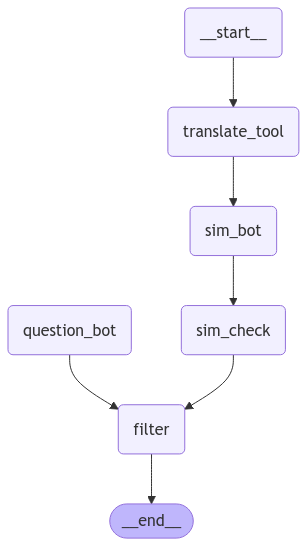

In [22]:
# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [24]:
query = """
Drehzahl (1/min):
400
Durchsatz (kg/h):
300
Gehäusetemperatur (°C):
Optional
270
Materialtemperatur (°C):
285
Zylinderdurchmesser:
Optional
51.5
Achsabstand:
Optional
41,5
Material:
PET1
Nicht-isotherm inkl. Particle Tracing

PET1
Wärmeleitfähigkeit: 0,22 W/mK
Wärmekapa: 1,93 kJ/kgK
Dichte: 1180 kg/m3

A 173,1447 Pa*s
B 0,002 s
C 0,04931
T:B 285°C
T:S 125°C

Zylinderdurchmesser:
51.5 mm
Achsabstand:
41,5 mm
Laenge:
41 mm
Kerndurchmesser:
30,9 mm
Schneckendurchmesser:
50,7 mm
Schneckenspiel:
0,72 mm

  type=OFF_LR
off_filelistL =  screw_-Y_extended_by_10.off,
off_filelistR screw_+Y_extended_by_10.off

vcut :: 0.38mm
srid :: 11115

eingaengig, single flight : NoOfFlights=1
"""
query2="What is the meaning of the off_filelist parameter?"
# Specify a thread
config = {"configurable": {"thread_id": "1"}}
messages = [HumanMessage(content=query)]
nextState = graph.invoke({"messages": messages, "ini_string": "Bullshit"}, config)
reply = nextState['messages'][-1].content

LLM returned a valid INI file


In [27]:
is_valid = validate_ini_schema(reply)
print(f"INI file is valid: {is_valid}")

INI file is valid: True


In [30]:
config_header = """ 
[SigmaFileInfo]
FileType=undefined
FileVersion=undefined
Date=undefined
SigmaVersion=undefined
ConfigId=undefined
"""
minimal_ini = """
[E3DGeometryData]

[E3DGeometryData/Machine]
Type=
Unit=
Zwickel=
MachineName=
RotationDirection=
BarrelDiameter=
CenterlineDistance=
BarrelStraightCut=
NoOfElements=
NoOfFlights=
BarrelLength=

[E3DGeometryData/Machine/Element_1]
GapScrewScrew=
ObjectType=
Unit=
startposition=
off_filelist=
off_filelistL=
off_filelistR=
innerdiameter=
outerdiameter=
type=

[E3DProcessParameters]
ScrewSpeed=
ProcessType=
MassThroughput=
MaterialTemperature=
BarrelTemperature=
ScrewTemperature=
BarrelTemperatureAdiabatic=
ScrewTemperatureAdiabatic=

[E3DProcessParameters/Material]
Name=
Type=

[E3DProcessParameters/Material/RheologicalData]
CalcVisco=
CalcTemp=

[E3DProcessParameters/Material/RheologicalData/Carreau]
ZeroViscosity=
RecipVelocity=
Exponent=

[E3DProcessParameters/Material/RheologicalData/TBTS]
standardtemperature=
referencetemperature=

[E3DProcessParameters/Material/ThermoData]
heatconductivity=
heatconductivityslope=
heatcapacity=
heatcapacityslope=
densitymodel=

[E3DProcessParameters/Material/ThermoData/Density]
Density=
DensitySlope=

[E3DSimulationsettings]
MeshQuality=
HexMesher=
KTPRelease=
"""
count_tokens_in_string(minimal_ini)

297